## Assignment 1 - Bayesian Analysis on a Grid 
#### Christopher Monaghan

In this assignment, we utilize Bayesian inference to characterize a spectral line by modeling provided data as a Gaussian with a known width $\omega = 1.0$, mean $x_{0} = 10.0$, and unknown parameters A and B:

$$m(x; A, B) = A e^{-\frac{(x-x_{0})^{2}}{2\omega^{2}}}+B$$

We'll perform a Bayesian analysis on a grid of values for A and B to determine the best Gaussian to fit the provided data.


#### 1 - Data and Physical Model

We'll start by defining a function for the Gaussian model that accepts an array for the x positions and an argument containing the parameters A and B. We'll then compare the supplied data in data.txt to a rough estimation for the best-fitting model, using A = 180 and B = 1860. For the data.txt error bars, we'll use $\sigma_{k} = \sqrt{N_{k}}$, where $N_{k}$ is the signal for each data point $k$ from data.txt.

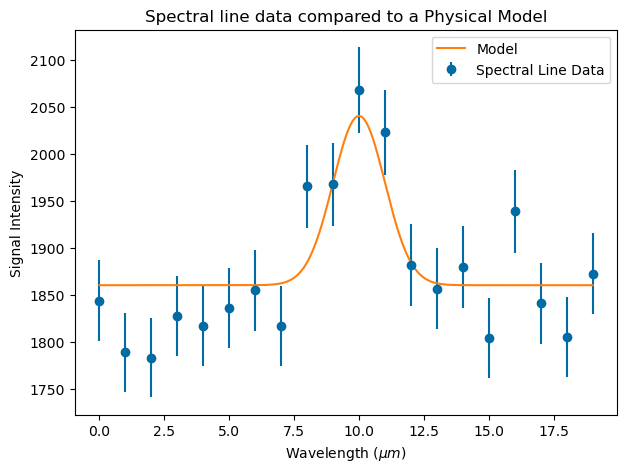

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm

#1a), b), c), and d)
plt.style.use('tableau-colorblind10') #Hopefully this works to make the colours easier

#We'll define a function for our Gaussian below, using the equation provided in the assignment 1 pdf
#p should take the form as a 2D array [A,B]
#0 <= A <= 1000, 0 <= B <=3000
def Gaussian(x: np.ndarray[float], p: np.ndarray[float], x0: float = 10.0, omega: float = 1.0) -> np.ndarray[float]: #the width (omega) and mean (x0) are known and set to default values.
    A, B = p #extract the A and B values from the p argument
    return A * np.exp(-(x-x0)**2/(2*omega**2))+B #return 'y' using the Gaussian equation above.

x_data, y_data = np.loadtxt('data.txt', unpack=True) #load in the values from data.txt

p_default = [180, 1860] #Save an argument for the default A and B values


#Generate the model data using the default values for A and B
x_model = np.linspace(min(x_data), max(x_data), 1000) #Well-sampled x-axis with 1000 points
y_model = Gaussian(x_model, p_default) #Generate the gaussian using the model defined above

#Time to plot!
plt.figure(figsize = (7,5))
#plt.errorbar allows us to plot the spectral line data with the y error bars
#the error in this case is the square root of the observed data
plt.errorbar(x_data, y_data, yerr = np.sqrt(y_data), fmt = 'o', label='Spectral Line Data') 
plt.plot(x_model, y_model, label='Model')
plt.xlabel("Wavelength ($\mu m$)") #no actual units for either axis are given, so I'm assuming microns :)
plt.ylabel("Signal Intensity") #no units here either, so I'm assuming some kind of unitless intensity
plt.legend()
plt.title("Spectral line data compared to a Physical Model")
plt.show()


With Bayesian inference, we can find a much better fit.

#### 2 - Implementing the probabilistic model

Using the methods outlined in the lectures and the textbook "Data Analysis: A Bayesian Tutorial" by D. S. Sivia, we'll implement the prior, likelihood, and posterior functions.

We'll assume a uniform prior distribution for both parameters A and B, assuming A is between 0 and 1000 and that B is between 0 and 3000.

In [38]:
#2a)

#We'll insert the default a and b boundaries into the function's definition
def prior_uniform(p: np.ndarray[float], a_bounds: np.ndarray[float] = [0, 1000], b_bounds: np.ndarray[float] = [0, 3000]) -> np.ndarray[float]:
    A, B = p #extract the A and B values from the p argument
    A_min, A_max = a_bounds #set the minimum and maximum values of each parameter using the supplied boundaries
    B_min, B_max = b_bounds
    
    #We use np.where and np.logical_and to calculate the prior for a given A and B value (or list of A and B values, with this formatting)
    #np.logical_and computes the truth value of both arguments
    #np.where returns 1/(max-min) if the np.logical_and returned True
    #Given that we have two parameters, we must multiply the probability for each to be the case.
    return (np.where(np.logical_and(A >= A_min, A <= A_max), 1/(A_max-A_min), 0) *  
            np.where(np.logical_and(B >= B_min, B <= B_max), 1/(B_max-B_min), 0))

print('Prior probability for [A, B] = ' + str(p_default) + ': ' + str(prior_uniform(p_default)))
    

Prior probability for [A, B] = [180, 1860]: 3.3333333333333335e-07


Next, we'll implement the Gaussian likelihood function. We use equation 2.14 from the textbook to calculate the likelihood for each data point in data.txt to have been measured, assuming the default values for A and B.

$$prob(x|\mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$$

Here, we take $\sigma$ as the error in each data point, defined as $\sqrt{N_{k}}$, and $\mu$ as the ideal data point, calculated using the Gaussian function implemented for Question 1 at each $x_{k}$.



In [39]:
#2b)
def likelihood_gaussian(x: np.ndarray[float], y: np.ndarray[float], p: np.ndarray[float], y_err: np.ndarray[float]) -> np.ndarray[float]: 
    
    prob_k = 1 #implement a variable to cumulatively integrate over each probability
    
    for k in range(len(x)): #for each data point in data.txt, calculate the gaussian likelihood using equation 2.14
        prob_k = prob_k * (1 / (y_err[k] * np.sqrt(2 * np.pi)) * 
                  np.exp(-(y[k] - Gaussian(x[k], p))**2/(2 * y_err[k]**2)))
        #We use the Gaussian function defined above the measure the ideal datum
        
        #because we have set of independent data, we must multiply all individual data likelihoods together
    return prob_k 

print('Likelihood for [A, B] = ' + str(p_default) + ': ' + str(likelihood_gaussian(x_data, y_data, p_default, np.sqrt(y_data))))


Likelihood for [A, B] = [180, 1860]: 3.888378992616983e-46


Finally, we'll implement the  function. This simply multiplies the results of the likelihood and prior functions above. Because we're not yet normalizing, we'll ignore the calculation of the evidence for now.

In [40]:
#2c)
def posterior(x: np.ndarray[float], y: np.ndarray[float], p: np.ndarray[float], y_err: np.ndarray[float]) -> np.ndarray[float]: 
    posterior_prob = likelihood_gaussian(x, y, p, y_err) * prior_uniform(p)
    #The posterior is simply the likelihood multiplied by the prior
    return posterior_prob

print('Posterior for [A, B] = ' + str(p_default) + ': ' + str(posterior(x_data, y_data, p_default, np.sqrt(y_data))))

Posterior for [A, B] = [180, 1860]: 1.2961263308723278e-52


#### 3 - Calculation of probability on a grid
To determine the best fitting values for A and B, we'll implement a 300x300 grid and calculate the 2D posterior distribution using the posterior outlined above.


100%|██████████| 300/300 [00:09<00:00, 32.05it/s]


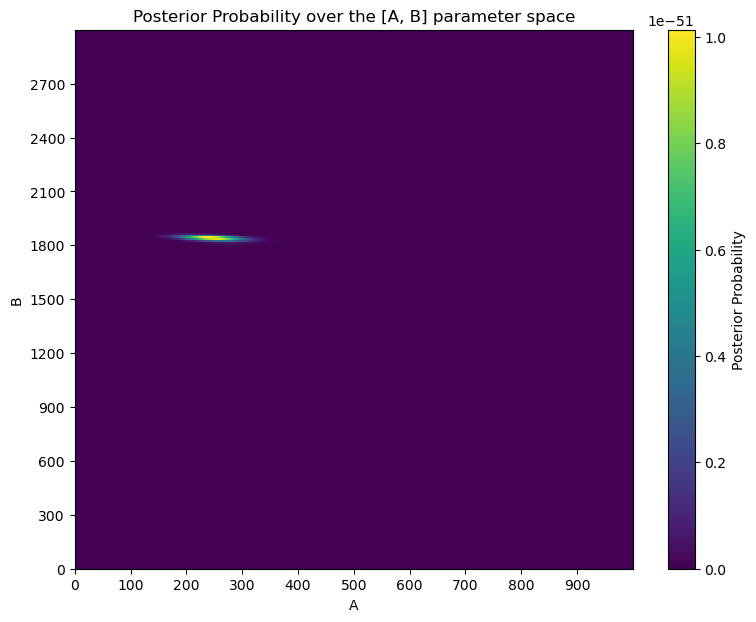

In [41]:
#3a), 3b)

#implement arrays for each parameter to form the grid
A_grid = np.linspace(0, 1000, 300)
B_grid = np.linspace(0, 3000, 300)

#generate an empty 300x300 grid to fill using the for loop below
posterior_grid = np.zeros((300,300), dtype=float)

#To avoid having the rewrite the functions above, we'll calculate the posterior for each point on the grid using a nested for loop.
#Faster methods are possible with some clever numpy formatting and array calculations / slicing, but to keep things simple we'll use this less-efficient method
#On the bright side, we can use tqdm to make a fancy progress bar.

#We iterate first over the B values, and then over the A values, to allow A to be the x axis and B the y axis of our 2D posterior
for j in tqdm.tqdm(range(len(B_grid))):
    for i in range(len(A_grid)):
        #Calculate the posterior for each A and B value on the grid
        posterior_grid[j][i] = posterior(x_data, y_data, [A_grid[i],B_grid[j]], np.sqrt(y_data))

#We'll use a slightly larger figure to allow for accessible viewing of the distribution and colorbar
plt.figure(figsize = (9,7))
#We use pcolormesh to show the 2D posterior of the grid
plt.pcolormesh(posterior_grid, cmap = 'viridis')
plt.xlabel("A") 
plt.ylabel("B")

#We want to show the x and y ticks as the A and B values, rather than the dimensions of the colormesh
#One way to reformat it is to specify the x and y ticks as the values we started with
#We only show 10 ticks on each axis to avoid overplotting

plt.xticks(np.arange(0,300,30), labels=np.arange(0,1000,100)) 
plt.yticks(np.arange(0,300,30), labels=np.arange(0,3000,300))
plt.title("Posterior Probability over the [A, B] parameter space")
plt.colorbar(label = 'Posterior Probability')
plt.show()

Most of the parameter space's posterior is zero! We'll 'zoom in' on the nonzero component by selecting a much smaller region of the grid. We specify our grid to only show A values between 100 and 400, and B values between 1800 and 1900. This should better showcase our posterior distribution.

100%|██████████| 300/300 [00:09<00:00, 31.97it/s]


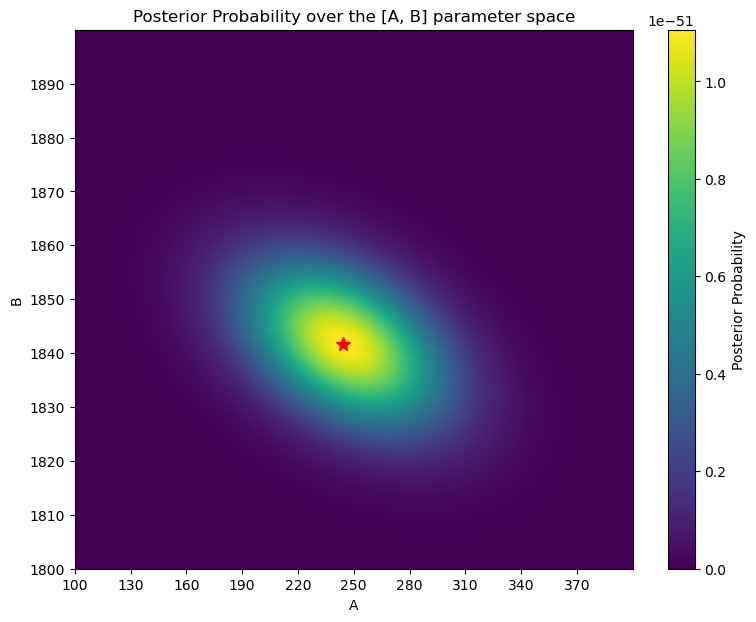

Maximum probability occurs at [A, B] = [244.48160535117057, 1841.8060200668897]


In [42]:
#3c), 3d)

#We'll define smaller bounds on A and B for our 300x300 grid
A_grid_small = np.linspace(100, 400, 300)
B_grid_small = np.linspace(1800, 1900, 300)

posterior_grid_small = np.zeros((300,300), dtype=float)

#We'll use the same method to calculate the posterior with the nested for loops.
for j in tqdm.tqdm(range(len(B_grid_small))):
    for i in range(len(A_grid_small)):
        posterior_grid_small[j][i] = posterior(x_data, y_data, [A_grid_small[i],B_grid_small[j]], np.sqrt(y_data))


#To determine the point of maximum probability, we'll use np.unravel_index to find the 'coordinates' of the best A and B values on the posterior_grid_small
max_prob_coords = np.unravel_index(posterior_grid_small.argmax(), posterior_grid_small.shape)

#We'll then extract the best A and B values using the coordinates above
B_best = B_grid_small[max_prob_coords[0]]
A_best = A_grid_small[max_prob_coords[1]]
max_prob_values = [A_best, B_best]

#We'll plot everything the same way as above for 3a) and 3b), but making sure to change the x and y ticks to our new parameter space.
plt.figure(figsize = (9,7))
plt.pcolormesh(posterior_grid_small, cmap = 'viridis')
plt.plot(max_prob_coords[1], max_prob_coords[0], 'r*', ms=10)
plt.xlabel("A") 
plt.ylabel("B")

plt.xticks(np.arange(0,300,30), labels=np.arange(100, 400, 30))
plt.yticks(np.arange(0,300,30), labels=np.arange(1800, 1900, 10))
plt.title("Posterior Probability over the [A, B] parameter space")
plt.colorbar(label = 'Posterior Probability')
plt.show()

print('Maximum probability occurs at [A, B] = ' + str(max_prob_values))

We've determined the A and B values that correspond to the maximum posterior. To confirm that the optimal values of A and B work well in fitting the data from data.txt, we'll generate a graph similar to the one from part 1. We'll also plot the residuals on a second panel. The residuals are simply the difference between the two models at each $x_{k}$.

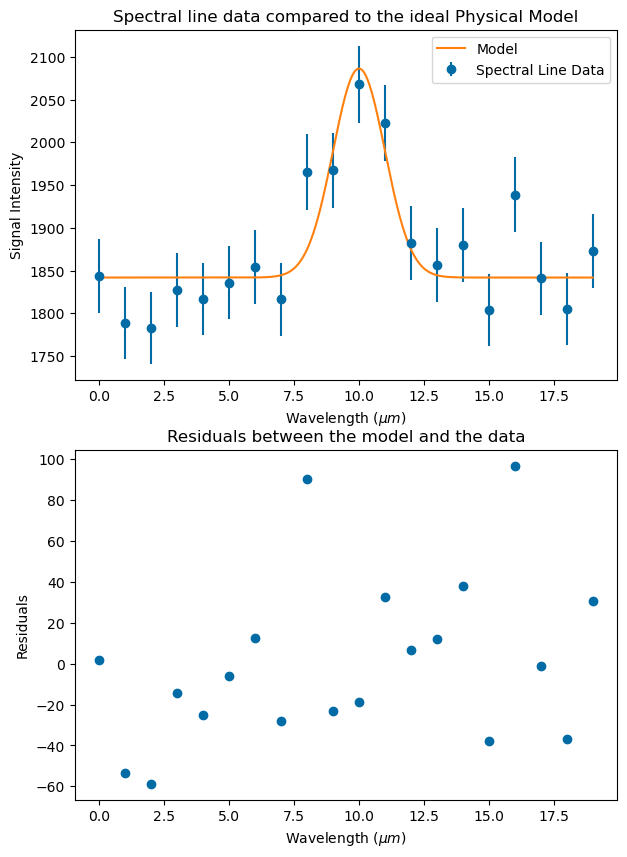

In [43]:
#3e)

#We'll use subplots to generate two different panels
fig, ax = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(7)

x_model = np.linspace(min(x_data), max(x_data), 1000) #Well-sampled x axis with 1000 points
y_model = Gaussian(x_model, max_prob_values) #Generate the gaussian using the model defined above, this time passing the optimal A and B values as the p argument.

ax[0].errorbar(x_data, y_data, yerr = np.sqrt(y_data), fmt = 'o', label='Spectral Line Data') 
ax[0].plot(x_model, y_model, label='Model')
ax[0].set_xlabel("Wavelength ($\mu m$)") 
ax[0].set_ylabel("Signal Intensity") 
ax[0].legend()
ax[0].set_title("Spectral line data compared to the ideal Physical Model")

#To measure the residuals, we'll make a second 'ideal' model, but this time only calculating the Gaussian at the xk values in data.txt
y_model_lowres = Gaussian(x_data, max_prob_values) #Generate the gaussian using the model defined above
residuals = (y_data - y_model_lowres) #residual = actual - predicted/ideal

#plot the residuals on the second panel using plt.scatter
ax[1].scatter(x_data, residuals)
ax[1].set_xlabel("Wavelength ($\mu m$)")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals between the model and the data")

plt.show()

#### 4 - Bayesian evidence and normalization

Next, we'll normalize the posterior probability distribution by calculating the Bayesian evidence. First, we'll compare the evidence between the two grids used in part 3.

If we treat the grids as continuous, then the two grids should have the same Bayesian evidence. By continuous, we mean that each 'pixel' on the 300x300 grid represents the probability that the A and B parameters 'reside' in the region outlined by the pixel size (or binsize of the grid):

$$P(N_{K}) = \int_{A_{min}}^{A_{max}}\int_{B_{min}}^{B_{max}}P_{NN}(A,B|N_{k}) dB dA \approx \sum_{A}\sum_{B} P(A_{i},B_{j}) \Delta B \Delta A $$

In [44]:
#4a)

#The Bayesian evidence can be calculated by integrating the probabilities over the entire parameter space

#For a continuous distribution within the grid,  we must account for the binsize of the grid
#For the large grid, the A binsize is 1000/300 = 10/3, while the B binsize is 3000/300 = 10

print("Assuming a continuous distribution:")

Bayesian_evidence_c = np.sum(posterior_grid) * 10/3 * 10
print('Bayesian evidence for 3a) =', Bayesian_evidence_c) 

#For the small grid, the A binsize is 300/300 = 1, while the B binsize is 100/300 = 1/3
Bayesian_evidence_small_c = np.sum(posterior_grid_small) * 1 * 1/3
print('Bayesian evidence for 3c) =', Bayesian_evidence_small_c)

Assuming a continuous distribution:
Bayesian evidence for 3a) = 2.476811098374519e-48
Bayesian evidence for 3c) = 2.4765737096777108e-48


Alternatively, if we assume a discrete grid, we don't account for the binsizes. By discrete, we mean that each pixel on the 300x300 grid represents the probability that A and B equal the central A and B values of that pixel. Without the binsize correction, the evidence for each grid now differs on an order of magnitude.

To simplify future calculations, we'll use the normalized version of the discrete grid to avoid worrying about the binsizes. This won't change the results of future questions.

To normalize the discrete grid, we'll simply divide the posterior by the bayesian evidence. If we wanted to normalize the continous grid, we'd have to account for the binsizes in the posterior distribution as well.

In [45]:
#4a) continued

Bayesian_evidence = np.sum(posterior_grid) #* 10/3 * 10
print('Bayesian evidence for 3a) =', Bayesian_evidence) 

Bayesian_evidence_small = np.sum(posterior_grid_small) #* 1 * 1/3
print('Bayesian evidence for 3c) =', Bayesian_evidence_small)


#Our prior calculation depends on whether or not we assume A and B as continuous or discrete in our parameter space. 
#If we assume both grids are discrete, the priors will be different, as shown above. However, if we assume that the distributions of A and B are continuous, we must account for the 'binsize' of each grid. Doing so results in both priors being equal.

#We'll assume that the values in the grid are discrete to simplify future calculations.

#4b)
#We'll normalize the grids by dividing each by the Bayesian evidence
posterior_grid_normalized = posterior_grid/np.sum(posterior_grid)
posterior_grid_small_normalized = posterior_grid_small/np.sum(posterior_grid_small)

#As a sanity check, we could print the integral over the normalized posterior grids and see that they're equal to one (with some floating point imprecision)
# print(np.sum(posterior_grid_normalized))
# print(np.sum(posterior_grid_small_normalized))

Bayesian evidence for 3a) = 7.430433295123557e-50
Bayesian evidence for 3c) = 7.429721129033133e-48


#### 5 - Probability contours / confidence intervals

Next, we'll overplot the 68%, 95% and 99.7% (1$\sigma$, 2$\sigma$, and 3$\sigma$) confidence intervals onto the small 2D posterior from part 3.

The easiest way to do this is to use plt.contours. To use this command, however, we must specify the 'levels' at which to plot the contours. We find the levels by integrating over the parameter space to find the rings that enclose 68%, 95%, and 99.7% of the total probability distribution. To perform this integration, we flatten the normalized posterior and sort it in decreasing order. We then cumulatively integrate until we find the levels at which we've integrated up to each confidence interval:

$$C_{68} = P_{N_{1}}, \sum_{n=0}^{N_{1}} P_{n} = 0.68; C_{95} = P_{N_{2}}, \sum_{n=0}^{N_{2}} P_{n} = 0.95; C_{99.7} = P_{N_{3}}, \sum_{n=0}^{N_{3}} P_{n} = 0.997$$

where $P$ represents the flattened array in decreasing order and $P_{n}$ represents the probability at index $n$.

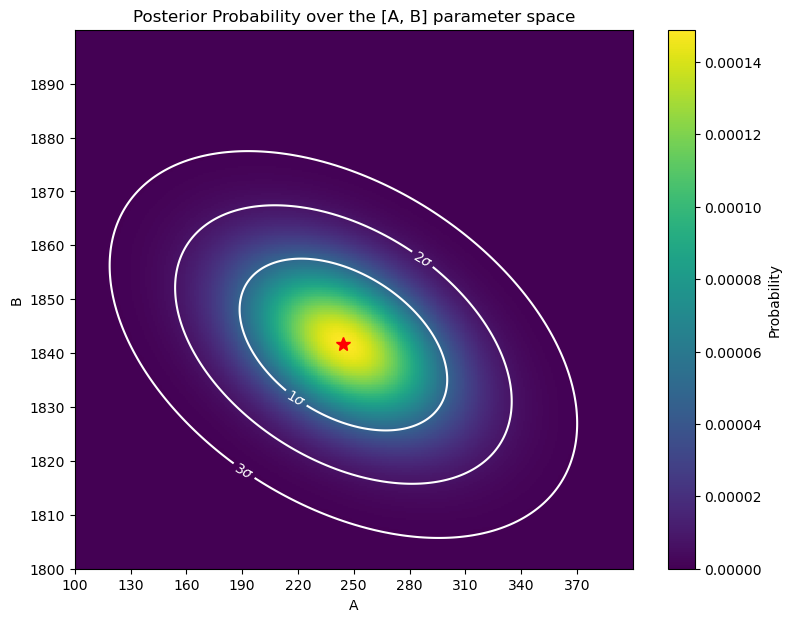

In [46]:
#5
plt.figure(figsize = (9,7))

#The confidence intervals can be calculated by integrating over the posterior probability distribution to find which regions in the (A,B) parameter space contain 68%, 95%, and 99.7% of the total distribution
#In order to plot these using plt.contours, we'll need to specify the 'levels' at which to plot the contours
#We'll find the levels by integrating over the parameter space, starting from the location of highest probability and moving down until we find the level that encloses 68%, 95%, or 99.7% of the total probability distribution, saving these levels, and then overplotting them.

confidence_intervals = [0.68,0.95,0.997]
contour_levels = [] #keeps track of the levels at which we plot (C68, C95, and C99.7 in the equations above
c = 0 #represents an additional counter to keep track of which interval we're calculating the contour level for
int_prob = 0 #represents our cumulative integration
flat_sort_probabilities = np.sort(posterior_grid_small_normalized, axis = None)[::-1] #generate our flattened posterior in decreasing order (P in the equation provided above)

#Perform our cumulative integration. 
for p in flat_sort_probabilities:
    int_prob += p
    if int_prob > confidence_intervals[c]: #If we've reached the desired confidence interval level
        contour_levels.append(p) #save the contour level
        c += 1 #move onto the next confidence interval
        if c == len(confidence_intervals): #Exit the loop to avoid unnecessary computations and avoid errors once we're out of confidence intervals to calculate
            break

#We'll now generate the contours using plt.contour and the levels calculated above
#Because the levels must be increasing, we'll reverse the order of our contours
CS = plt.contour(posterior_grid_small_normalized, colors='white', levels=contour_levels[::-1])

#plot the small normalized grid using pcolormesh like before
plt.pcolormesh(posterior_grid_small_normalized, cmap = 'viridis')
#We'll leave the maximum probability in the plot for clarity
plt.plot(max_prob_coords[1], max_prob_coords[0], 'r*', ms=10)


#To label the contours, we'll use formatting using the method outlined in the matplotlib contour label demo
fmt = {}
strs = ['$3\sigma$', '$2\sigma$', '$1\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s

plt.clabel(CS, CS.levels, fmt=fmt,colors='white')

#Finally, we'll complete the figure
plt.xlabel("A") 
plt.ylabel("B")

plt.xticks(np.arange(0,300,30), labels=np.arange(100, 400, 30))
plt.yticks(np.arange(0,300,30), labels=np.arange(1800, 1900, 10))
plt.title("Posterior Probability over the [A, B] parameter space")
plt.colorbar(label = 'Probability')
plt.show()

# print(np.sum(np.where(posterior_grid_small_normalized > 4.7648624780803436e-05, posterior_grid_small_normalized, 0)))


#### 6 - Means, medians, and covariances

Next, we'll calculate the mean, median, and covariance of the 2D posterior. We'll outline the formulas here before presenting the code to calculate them:


#### Mean:
The mean of a 2D distribution can be calculated using the equation below:
$$<A> = \int_{A_{min}}^{A_{max}}\int_{B_{min}}^{B_{max}}A\,P(A,B) dA dB$$
For our 300x300 grid, we can calculate the mean using $\sum A\,P(A,B)$ where we sum over the entire 300x300 grid. We perform this summation for both $<A>$ and $<B>$. We'll also calculate the uncertainty in the A and B means using:

$$\sigma_{A} = \sqrt{\sigma^{2}_{A}} \hspace{2cm} \sigma_{B} = \sqrt{\sigma^{2}_{B}}$$

where $\sigma^{2}_{A}$ and $\sigma^{2}_{B}$ are the A and B variances. The equation to calculate these will be shown below in the definition of the covariance.

#### Median:
The median $x_{med}$ of a 1D distribution is defined as the following:

$$\int_{-\infty}^{x_{med}}P(x|D)dx = \int_{x_{med}}^{\infty}P(x|D)dx = 0.5$$

To find the median A and B values in our 2D posterior, we'll have to marginalize our distributions into a 1D posterior ($P(A|D)$ and $P(B|D)$) before using the equation above to find the median:

$$P(A|D) = \int_{B_{min}}^{B_{max}}P(A,B|D)dB \hspace{2cm} P(B|D) = \int_{A_{min}}^{A_{max}}P(A,B|D)dA$$

To perfom this equation in our code, we can use np.sum over one of the two axes and return an array with 300 indices to find the marginalized probability. Then, we'll cumulatively integrate the marginalized probability until we've integrated up to 50% of the total probability distribution, like we'd done before for the contour confidence intervals. The corresponding A or B median values can then be extracted. To report the uncertainty in the median, we'll calculate the 16th and 84th percentiles using the same cumulative integation method:

$$A_{med} = A_{50}_{-A_{50}-A_{16}}^{+A_{84}-A_{50}} \hspace{2cm} B_{med} = B_{50}_{-B_{50}-B_{16}}^{+B_{84}-B_{50}}$$

#### Covariance Matrix:

The covariance matrix generalizes the variance of multidimensional posterior distributions, and is calculated with the following for a 2D distribution:

$$\sum = \left(\begin{array}{cc} \sigma^{2}_{A} & \sigma^{2}_{AB}\\
 \sigma^{2}_{AB} & \sigma^{2}_{B}\end{array}\right)$$
 
where $\sigma^{2}_{A}$ represents the variance in the A dimension, $\sigma^{2}_{B}$ the variance in the B dimension, and $\sigma^{2}_{AB}$ the covariance. The variances are calculated as follows:

$$\sigma^{2}_{A} = <(A-<A>)^{2}> = \int_{A_{min}}^{A_{max}}\int_{B_{min}}^{B_{max}}(A-<A>)^{2}\,P(A,B) dA dB$$
$$\sigma^{2}_{B} = <(B-<B>)^{2}> = \int_{A_{min}}^{A_{max}}\int_{B_{min}}^{B_{max}}(B-<B>)^{2}\,P(A,B) dA dB$$
$$\sigma^{2}_{AB} = <(A-<A>)(B-<B>)> = \int_{A_{min}}^{A_{max}}\int_{B_{min}}^{B_{max}}(A-<A>)(B-<B>)\,P(A,B) dA dB$$

For our 300x300 grid, we can calculate each variance term using $\sigma^{2}_{A} = \sum (A-<A>)^{2}\,P(A,B)$, $\sigma^{2}_{B} = \sum (B-<B>)^{2}\,P(A,B)$, and $\sigma^{2}_{AB} = \sum (A-<A>)(B-<B>)\,P(A,B)$ where we sum over the entire 300x300 grid. We'll use the means calculated earlier for $<A>$ and $<B>$.
 

In [47]:
#6a), 6b), and 6c)


#Since we use the cumulative integration method twice, we'll throw the for loop into a function to avoid duplicated code
#The formatting is nearly the same as before for the contour levels calculation. 
#However, this time we return the median value, rather than the 'level' at which we integrated 50% of the distribution
def find_median(x: np.ndarray[float], y: np.ndarray[float]) -> np.ndarray[float]:
    int_tot = 0
    for i in range(len(x)):
        int_tot += y[i]
        if int_tot >= np.sum(y)/2: #if we've reached half of the total distribution
            return x[i]


#We'll write a similar function to determine the error bars on the median
#This time we find the x values for which we've integrated 16% and 84% of the distribution
#Then, we return x50-x16 and x84-x50
def find_uncertainty(x: np.ndarray[float], y: np.ndarray[float], x0: float) -> np.ndarray[float]:
    confidence_intervals = [0.16, 0.84]
    interval_coordinates = []
    c = 0
    int_prob = 0

    for i, p in enumerate(y):
        int_prob += p
        if int_prob > confidence_intervals[c]:
            interval_coordinates.append(x[i])
            c += 1
            if c >= len(confidence_intervals):
                unc_low = x0-interval_coordinates[0]
                unc_high = interval_coordinates[1]-x0
                return [unc_low, unc_high]

post_AB = np.copy(posterior_grid_small_normalized) #We'll simplify this somewhat long variable name by making a new copy with a simple name

#We'll calculate the mean using the summation method described above. To do this, we'll initialize two variables that we'll sum over using a nested for loop
A_mean = 0
B_mean = 0

#Calculate the A and B means
for j, B in enumerate(B_grid_small):
    for i, A in enumerate(A_grid_small):
        A_mean += A * post_AB[j][i]
        B_mean += B * post_AB[j][i]

#We'll calculate the variance and covariance using the nested for loop summation, in a similar method to the mean calculation
cov_AB = 0
var_A = 0
var_B = 0

#Calculate the covariance and variance using the equations above and the A and B means from earlier.
for j, B in enumerate(B_grid_small):
    for i, A in enumerate(A_grid_small):
        cov_AB += (A-A_mean) * (B-B_mean) * post_AB[j][i]
        var_A += (A-A_mean)**2 * post_AB[j][i]
        var_B += (B-B_mean)**2 * post_AB[j][i]
        
#We can use the var_A and var_B to calculate the uncertainty in the mean for A and B

print("Mean of A = " + str(A_mean) + u" \u00B1 " + str(np.sqrt(var_A)))
print("Mean of B = " + str(B_mean)+  u" \u00B1 " + str(np.sqrt(var_B)))

#Use the median functions above to calculate and print the median values and associated uncertainties
A_med_unc = find_uncertainty(A_grid_small, np.sum(post_AB, axis=0), A_mean)
B_med_unc = find_uncertainty(B_grid_small, np.sum(post_AB, axis=1), B_mean)

print("\nMedian of A = " + str(find_median(A_grid_small, np.sum(post_AB, axis=0))) 
      + " ( +" + str(A_med_unc[1]) + " -" + str(A_med_unc[0]) + ")")
print("Median of B = " + str(find_median(B_grid_small, np.sum(post_AB, axis=1)))
      + " ( +" + str(B_med_unc[1]) + " -" + str(B_med_unc[0]) + ")")

#Finally, we can format and print the covariance matrix:
covariance_matrix = np.array([[var_A, cov_AB],[cov_AB, var_B]])

print("\nCovariance Matrix:")
print(covariance_matrix)


Mean of A = 244.91005662941996 ± 37.07425524740551
Mean of B = 1841.733834006657 ± 10.586648944320487

Median of A = 244.48160535117057 ( +36.6952945411486 -36.54885261604204)
Median of B = 1841.8060200668897 ( +10.440079036821317 -10.630155076891015)

Covariance Matrix:
[[1374.50040215 -159.95220681]
 [-159.95220681  112.07713587]]


#### 7 - Marginal and conditional distributions

Finally, we'll plot and compare the marginal distribution $P(A|D)$ to a conditional distribution $P(A|D, B=B*)$. We'll marginalize the same was as we defined it above for the median calculation.

To calculate $P(A|D, B=B*)$ we'll simply extract the row of B=B* from our 2D posterior and normalize it


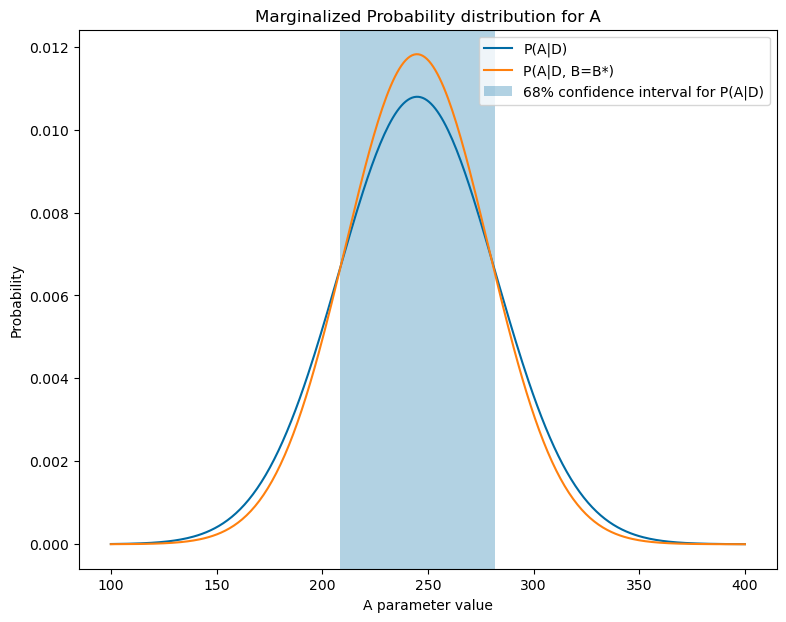

In [48]:
#7a), 7b), and 7c)
#Marginalize our 2D posterior:

post_A = np.sum(post_AB, axis=0) #P(A|D)
#post_B = np.sum(post_AB, axis=1) #P(B|D)

post_A_Bstar = post_AB[max_prob_coords[0]] #P(A|D, B=B*)
post_A_Bstar = post_A_Bstar/np.sum(post_A_Bstar) #Normalize the conditional probability by dividing by the Bayesian evidence

#We'll use a loop similar to the one implemented for questions 5 and 6 to calculate the 68% confidence interval
#We'll do so by calculating the A values for which 16% and 84% of the probability distribution is constrained between Amin (A=0) and A16 / A84.

confidence_intervals = [0.16, 0.84]
interval_coordinates = []
c = 0
int_prob = 0

for i, p in enumerate(post_A):
    int_prob += p
    if int_prob > confidence_intervals[c]:
        interval_coordinates.append(A_grid_small[i])
        c += 1
        if c >= len(confidence_intervals):
            break

plt.figure(figsize = (9,7))
plt.plot(A_grid_small, post_A, label='P(A|D)')
plt.plot(A_grid_small, post_A_Bstar, label='P(A|D, B=B*)')
plt.axvspan(interval_coordinates[0], interval_coordinates[-1], alpha=0.3, label='68% confidence interval for P(A|D)')
plt.xlabel("A parameter value")
plt.ylabel("Probability")
plt.title("Marginalized Probability distribution for A")
plt.legend()
plt.show()


The distributions shown above vary slightly as $P(A|D, B=B*)$ is a conditional distribution, specifying that B must equal the value corresponding to the maximum probability from Question 3. The marginalized probability is independent of B, while the conditional is dependent on B=B*. As shown by the shape of the 2D posterior and the covariance calculated in 6c), the posterior probability depends on the values of A and B. Thus, $P(A|D)$ and $P(A|D, B=B*)$ will be different. The two would only be equivalent if the covariance of the 2D posterior were 0.